In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import math
import sys
import os

import random
from scipy.stats import rice

In [2]:
import ipdb

In [3]:
"""
Questions :
Est-ce que le E dans la formule de perte est une esperance ou une entropie ? 
A la fin on fait 
Chaque pacient as X images par dossier est-ce que on considere ce dossier on doit 
le considerer comme un ensamble d'images et que notre bute final est de debruiter l'ensamble d'images oubien
on les considere comme des images separer ? (pour le moment je les considere comme des images separer)

"""

"\nQuestions :\nEst-ce que le E dans la formule de perte est une esperance ou une entropie ? \nA la fin on fait \nChaque pacient as X images par dossier est-ce que on considere ce dossier on doit \nle considerer comme un ensamble d'images et que notre bute final est de debruiter l'ensamble d'images oubien\non les considere comme des images separer ? (pour le moment je les considere comme des images separer)\n\n"

In [4]:
def format_data_numpy(noised,denoised):
    data = []
    for i in range(denoised.shape[0]):
        pair = np.stack((noised[i],denoised[i]),axis=0)
        data.append(pair)
        
    data = np.array(data)
    return data

In [26]:
def format_data(noised, denoised):
    #assert noised.shape == denoised.shape, "Input tensors must have the same shape."
    if noised.shape[0] != denoised.shape[0]:
        dmin = min(noised.shape[0],denoised.shape[0])
        noised = noised[:dmin]
        denoised = denoised[:dmin]
        
    if noised.shape != denoised.shape:
        print(f"The shapes are : {noised.shape} and {denoised.shape}")
        raise ValueError(f"Input tensors must have the same shape. ")
    data = torch.stack((noised, denoised), dim=1)
    return data

In [6]:
def separate_data(data):
    assert data.shape[1] == 2, "Input tensor must have as second dim = 2 shape[1]"
    noised, denoised = torch.split(data, 1,dim=1)
    noised = noised.squeeze(1)
    denoised = denoised.squeeze(1)
    return noised, denoised 

General parameters of models :

In [7]:
lr = 0.0002

## Generator :
The generator takes denoised images and returnes noised images

In [31]:
#Generateur
#nb_feat : c'est le nombre de features que notre modele va gere 

class Generator1(nn.Module):
    def __init__(self, input_dim,out_dim):
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        self.out_dim = out_dim
        
        self.main = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, out_dim, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            
            #nn.ConvTranspose2d(32, out_dim, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(out_dim),            
            nn.ReLU(),
            
            nn.Conv2d(out_dim, out_dim, kernel_size=4, stride=2, padding=1),
            nn.Tanh() 
        )

    def forward(self, x):
        print("The x shape",x.shape)
        x = x.unsqueeze(1)  # Add a channel dimension
        print("x shape after unsqueeze",x.shape)
        return self.main(x)

In [61]:
#Generateur
#nb_feat : c'est le nombre de features que notre modele va gere 

class Generator(nn.Module):
    def __init__(self, input_dim,out_dim):
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        self.out_dim = out_dim
        
        self.main = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, out_dim, kernel_size=4, stride=2, padding=1),  # Final output
            nn.Tanh()  # Final activation
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        return self.main(x)

## Denoiser

In [9]:
class Denoiser(nn.Module):
    def __init__(self, nb_feat):
        super(Denoiser, self).__init__()
        self.nb_feat = nb_feat
        self.main = nn.Sequential(
            nn.Linear(nb_feat,100),
            nn.Tanh(),
            nn.Linear(100,nb_feat),
            nn.Tanh()
    )

    def forward(self, x):
        return self.main(x)

## Discriminator 
Takes two images and has to say if this pair of images is a real one or if it's fake => it takes the stack of the 2 images

In [10]:
class Discriminator(nn.Module):
    def __init__(self,nb_feat):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            #Convolutional layer
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            
            #Convolutional layer
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            #Convolutional layer
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,1, kernel_size=4, stride=2, padding=1),
            
            nn.Flatten(),
            nn.Linear(24 * 24, 1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        return self.main(x)

In [67]:
generator = Generator(240,1)
denoiser = Generator(240,1)#Denoiser(384)
discriminator = Discriminator(384)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

The loss function follows the entropie :

In [12]:
class FLoss(nn.Module):
    def __init__(self):
        super(FLoss, self).__init__()
        
    def forward(self, logits, labels):
        # Example: Custom loss combining standard GAN loss with an additional term
        if logits.shape != labels.shape:
            raise ValueError("Input and labels must have the same shape")
            
        sigmoid_logits = torch.sigmoid(logits) 
        loss = ( labels * torch.log(sigmoid_logits + 1e-12) - 
                  (1 - labels) * torch.log(1 - sigmoid_logits + 1e-12))

        return loss.mean()


Now that we have our loss function we want to initialise the optimizer of our models, that we are going to add in the train function

In [13]:
#optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)
#optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)

Then we have the training loop : \
We know that our dataloader gives us the truth so all the labels are set to true/1

Note : my data contain the denoised image and the the noised one stack behind. Also we have 

In [14]:
"""
In order to call the model we have to :
- get the data reformat 
- create the models
- 
Note the  dataloaders with the noised,denoised and labels 

"""


'\nIn order to call the model we have to :\n- get the data reformat \n- create the models\n- \nNote the  dataloaders with the noised,denoised and labels \n\n'

Note : \
with the use of `.detach()` you ensure that the gradients from the discriminator do not flow back to the generator during the backward pass.

We get our transformed data :

In [15]:
def bruitage_racien(image,b = 0,loc=0,scale=1):
    noise = rice.rvs(b, loc=loc, scale=scale, size=image.shape)
    noisy_image = np.clip(image+noise, 0, 255)
    
    return noisy_image

For my data I want to change the data I want to extract them all and noised them.

In [16]:
def extract_nii_data(source_directory ,typeOfdata = '2_t2_tse_sag'):
    all_images = []
    #we iterate in the main directory
    for name in os.listdir(source_directory):
        #iteration for each patient
        inner_directory = source_directory+"/"+name
        for filename in os.listdir(inner_directory):
            #extract only the type we want t1,t2 
            if typeOfdata in filename :
                print(filename)
                all_images.append(np.array((nib.load(inner_directory+"/"+filename)).dataobj))
    # Check if the list is not empty         
    if all_images:  
        concatenated_images = np.concatenate(all_images, axis=0)
    else:
        concatenated_images = np.array([])
    return concatenated_images

In [17]:
data = extract_nii_data("./test")
data.shape

2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii
2_t2_tse_sag_384.nii


(133, 384, 384)

In [18]:
"""
The data that we noise we know that are images
"""
def noise_all_data(fnoise,data):
    assert data.ndim == 3,"Wrong type of data"
    noised = []
    for im in data: 
        noised.append(fnoise(im))
    noised = np.array(noised)
    return noised   

In [19]:
noised = noise_all_data(bruitage_racien,data)
noised.shape

(133, 384, 384)

In [20]:
#plt.imshow(np.rot90(noised[0]), cmap='gray')

In [21]:
#plt.imshow(np.rot90(data[0]), cmap='gray')

In [36]:
denoised_torch = torch.tensor(data, dtype=torch.float32) 
noised_torch = torch.tensor(noised, dtype=torch.float32) 

data_torch = format_data(noised_torch,denoised_torch)

data_torch.shape

(torch.Size([133, 2, 384, 384]), torch.Size([133, 384, 384]))

Note the labels will depend on the MODEL :

In [23]:
#data_tensor = torch.from_numpy(data).float()/255.0
dataset = TensorDataset(denoised_torch, noised_torch)

batch_size = 10 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#veryfication loop
for batch_denoised, batch_noised in dataloader:
    print(f"denoised : {batch_denoised.shape}, noised: {batch_noised.shape}")

batch_denoised, batch_noised = next(iter(dataloader))
noised_image = batch_noised[0]
denoised_image = batch_denoised[0]

denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([10, 384, 384]), noised: torch.Size([10, 384, 384])
denoised : torch.Size([3, 384, 384]), 

In [ ]:
def train(data_loader,num_epochs,g_model,d_model,r_model,nb_feat,alpha,n_critic,loss_fn):
    
    optimizer_g = torch.optim.Adam(g_model.parameters(), lr=lr)
    optimizer_d = torch.optim.Adam(d_model.parameters(), lr=lr)
    optimizer_r = torch.optim.Adam(r_model.parameters(), lr=lr)
    
    g_model = g_model.to(device)
    d_model = d_model.to(device)
    r_model = r_model.to(device)
    
    #while loss small engouh
    
    for e in range(num_epochs):
        print(f"epoch {e} done")
        for n in range(n_critic):
            print(f"critic {n} done")
            for i, (denoised,noised) in enumerate(data_loader):

                #place it on the machine 
                noised = noised.to(device)
                denoised = denoised.to(device)
                #def separate to noised and denoised

                #labels
                fake_labels = torch.zeros(noised.size(0), 1, device=device)
                real_labels = torch.ones(noised.size(0), 1, device=device)


                ########################
                #Discriminator Training# 
                ########################

                optimizer_d.zero_grad()

                #optimize the discriminator by giving the real images
                print("this done 1")
                real_data = format_data(noised,denoised)
                real_output = d_model(real_data)

                #generate fake data (start by giving a random noise)
                z = torch.randn(batch_size, nb_feat,nb_feat, device=device)#TODO : fix the size depending of the dataloaders
                fake_data_noised = (g_model(z)).squeeze(1) 
                fake_data_denoised = (r_model(noised)).squeeze(1)
                print("this done 2")
                #(x_hat,y) : fake real
                fake_real = format_data(fake_data_noised,denoised)
                fake_real_out = d_model(fake_real)
                print("this done 3")
                #(x,y_hat) : real fake
                real_fake = format_data(noised,fake_data_denoised)
                real_fake_out = d_model(real_fake)
                #ipdb.set_trace()
                #optimize the discriminator by giving the generated images

                d_loss_real = loss_fn(real_output,real_labels)
                d_loss_real_fake = loss_fn(real_fake_out,fake_labels)
                d_loss_fake_real = loss_fn(fake_real_out,fake_labels)

                d_loss = d_loss_real - (alpha)*d_loss_fake_real - (1-alpha)*d_loss_real_fake 
                d_loss.backward()
                optimizer_d.step()
                print("this done")
                #ipdb.set_trace()
                # Print losses
                if i % 100 == 0:
                    print(f'Epoch [{e+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], '
                      f'Discriminator Loss: {d_loss.item():.4f}')
         
        print("We go here")
        for i, (denoised,noised) in enumerate(data_loader):

            #place it on the machine 
            noised = noised.to(device)
            denoised = denoised.to(device)

            #labels
            fake_labels = torch.zeros(noised.size(0), 1, device=device)
            real_labels = torch.ones(noised.size(0), 1, device=device)


            ####################
            # Update Generator # 
            ####################

            optimizer_g.zero_grad()


            fake_data_denoised = (r_model(noised)).squeeze(1)
            
            #fake_data = fake_data_noised + fake_data_denoised
            real_fake = format_data(noised,fake_data_denoised)
            real_fake_out = d_model(real_fake)


            g_loss =  alpha*loss_fn(real_fake_out,fake_labels)
            g_loss.backward()
            optimizer_g.step()

            ###################
            # Update Denoizer # 
            ###################

            optimizer_r.zero_grad()

            fake_data_noised = (g_model(denoised)).squeeze(1)
            fake_real = format_data(fake_data_noised,denoised)
            fake_real_out = d_model(fake_real)

            r_loss =(1-alpha)*loss_fn(fake_real_out,fake_labels)
            r_loss.backward()
            optimizer_r.step()
            
            if i % 100 == 0:
                print(f'Epoch [{e+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], '
                      f'R : Denoiser Loss: {r_loss.item():.4f}')
                

In [68]:
lr = 0.0002
loss_fn = torch.nn.BCEWithLogitsLoss()
train(dataloader,10,generator,discriminator,denoiser,384,0.5,2,loss_fn)

epoch 0 done
critic 0 done
this done 1
this done 2
this done 3
this done
Epoch [1/10], Step [1/14], Discriminator Loss: -0.5195
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
critic 1 done
this done 1
this done 2
this done 3
this done
Epoch [1/10], Step [1/14], Discriminator Loss: -0.9971
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done

this done 2
this done 3
this done
critic 1 done
this done 1
this done 2
this done 3
this done
Epoch [6/10], Step [1/14], Discriminator Loss: -1.0000
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
this done 1
this done 2
this done 3
this done
We go here
Epoch [6/10], Step [1/14], R : Denoiser Loss: 0.6566
epoch 6 done
critic 0 done
this done 1
this done 2
this done 3
this done
Epoch [7/10], Step [1/14], Discriminator Loss: -1.0000
this done 1
this done 2
this done 3
this done
this done 1
thi

Have to think about the labaling :
So easy for the denoiser and for the generator because we only have 1 input.For the discriminator we consider that if at least one is not the real one then the label is fake so 0 otherwise it's 1(true).

In [70]:
torch.save(discriminator.state_dict(), 'd_model.pth')
torch.save(generator.state_dict(), 'g_model.pth')
torch.save(denoiser.state_dict(), 'r_model.pth')

torch.Size([10, 384, 384])


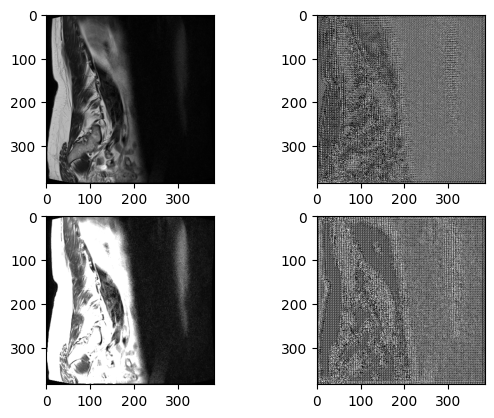

In [71]:
fig, axis = plt.subplots(2, 2)

axis[0,0].imshow(np.rot90(data[0]), cmap='gray')
axis[1,0].imshow(np.rot90(noised[0]), cmap='gray')


t1 = torch.from_numpy(data[0]).float()/255.0
t1_expanded = t1.unsqueeze(0).expand(10, -1, -1)
t2 = torch.from_numpy(noised[0]).float()/255.0
t2_expanded = t2.unsqueeze(0).expand(10, -1, -1)
print(t1_expanded.shape)
fake_im = (generator(t1_expanded).detach().numpy()).squeeze(1)
den_im = (denoiser(t2_expanded).detach().numpy()).squeeze(1)
axis[0,1].imshow(np.rot90(fake_im[0]), cmap='gray')
axis[1,1].imshow(np.rot90(den_im[0]), cmap='gray')


In [59]:
(fake_im[0]).shape

(384, 384)

This function takes as arguments the original data set and the generated one. Then it calculates the diferences in order to check the accuracy

In [ ]:
def accuracy():
    pass

For saving the trained model

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth', map_location=torch.device('cpu')))